****I USED CONTINOUS BAG OF WORDS****

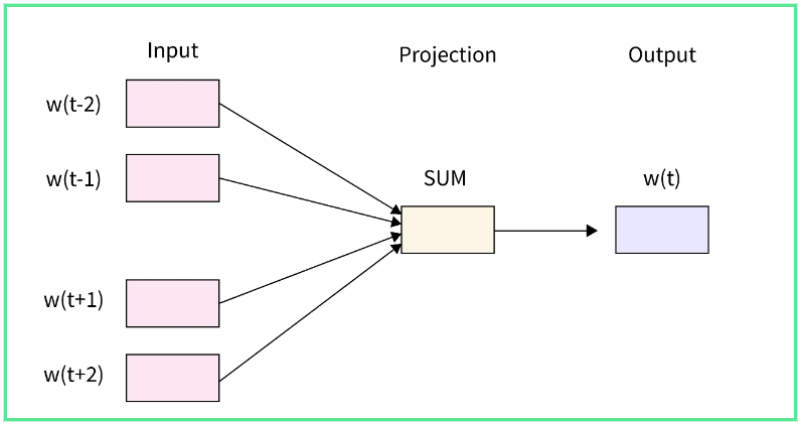

In [2]:
!pip install wikipedia-api

  Preparing metadata (setup.py) ... - done
  Created wheel for wikipedia-api: filename=Wikipedia_API-0.8.1-py3-none-any.whl size=15381 sha256=1ca27bab026b7b53a3dd3fbbcf6372b364b3ae8e55b4ae5aad0bd727ebbb9e34
  Stored in directory: /root/.cache/pip/wheels/1d/f8/07/0508c38722dcd82ee355e9d85e33c9e9471d4bec0f8ae72de0
Successfully built wikipedia-api


In [3]:
import re

# PyTorch Libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader  

# NLP Libraries
import wikipediaapi
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE

# Download required NLTK data
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

GETTING SOME DATA FROM WIKIPEDIA API

In [4]:
# Specify a user agent string
user_agent = 'My Wikipedia Scraper/1.0 (https://example.com/contact)'

# Initialize the Wikipedia API with the user agent
wiki_wiki = wikipediaapi.Wikipedia(
    language='en',
    user_agent=user_agent
)

# List of Wikipedia pages to scrape
pages_to_scrape = [
    "Natural language processing",
    "Part-of-speech tagging",
    "Sentiment analysis",
    "Gradient descent",
    "Backpropagation",
    "Activation function"
]

# Fetch, clean, and store content from Wikipedia pages
all_texts = []

for page_name in pages_to_scrape:
    page = wiki_wiki.page(page_name)
    if page.exists():
        content = page.text
        all_texts.append(content)
    else:
        print(f"Page '{page_name}' does not exist.")
corpus = " ".join(all_texts)

In [5]:
corpus[:1000]

'Natural language processing (NLP) is a subfield of computer science and especially artificial intelligence. It is primarily concerned with providing computers with the ability to process data encoded in natural language and is thus closely related to information retrieval, knowledge representation and computational linguistics, a subfield of linguistics. Typically data is collected in text corpora, using either rule-based, statistical or neural-based approaches in machine learning and deep learning.\nMajor tasks in natural language processing are speech recognition, text classification, natural-language understanding, and natural-language generation.\n\nHistory\nNatural language processing has its roots in the 1950s. Already in 1950, Alan Turing published an article titled "Computing Machinery and Intelligence" which proposed what is now called the Turing test as a criterion of intelligence, though at the time that was not articulated as a problem separate from artificial intelligence

In [6]:
def clean_text(corpus):
        text = re.sub(r'[^a-zA-Z\s-]', '', corpus)  #to remove everything except english alphabets and hyphens
        text = re.sub(r'-', ' ', text) #replace hyphens with empty space
        text = text.lower()
        words = word_tokenize(text) #refer the library
      # to remove single characters from the text(because it contains math formulas seperared by a space which results in more noise)
        words = [word for word in words if len(word) > 1] 
       #to remove frequent english words like "a", "this", "of" etc  - to reduce noise
        stop_words = set(stopwords.words('english'))
        words = [word for word in words if word not in stop_words]
        return words
cleaned_corpus = clean_text(corpus)

In [7]:
sample_text = " ".join(cleaned_corpus) 
sample_text[:1000]

'natural language processing nlp subfield computer science especially artificial intelligence primarily concerned providing computers ability process data encoded natural language thus closely related information retrieval knowledge representation computational linguistics subfield linguistics typically data collected text corpora using either rule based statistical neural based approaches machine learning deep learning major tasks natural language processing speech recognition text classification natural language understanding natural language generation history natural language processing roots already alan turing published article titled computing machinery intelligence proposed called turing test criterion intelligence though time articulated problem separate artificial intelligence proposed test includes task involves automated interpretation generation natural language symbolic nlp early premise symbolic nlp well summarized john searles chinese room experiment given collection ru

In [8]:
vocab = sorted(set(cleaned_corpus))
word_to_idx = {word: i for i, word in enumerate(vocab)}
idx_to_word = {i: word for word, i in word_to_idx.items()}
text_indices = [word_to_idx[word] for word in cleaned_corpus]
len(text_indices)

12322

In [9]:
class CBOWDataset(Dataset):
    def __init__(self, text, vocab, word_to_idx, context_size):
        self.data = []
        for i in range(context_size, len(text) - context_size):
            context = [text[i - context_size + j] for j in range(context_size)] + \
                      [text[i + j] for j in range(1, context_size + 1)]
            target = text[i]
            self.data.append((torch.tensor(context, dtype=torch.long), torch.tensor(target, dtype=torch.long)))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np

# Hyperparameters
EMBEDDING_DIM = 128  # Dimension of word embeddings
CONTEXT_SIZE = 4  # Number of context words (2 on each side)
LEARNING_RATE = 0.001
BATCH_SIZE = 32
EPOCHS = 50

# Define the CBOW model
class CBOW(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super(CBOW, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)  # Embedding layer
        self.linear = nn.Linear(embedding_dim, vocab_size)  # Output layer

    def forward(self, inputs):
        # inputs: (batch_size, CONTEXT_SIZE)
        embedded = self.embeddings(inputs)  # (batch_size, CONTEXT_SIZE, embedding_dim)
        embedded_sum = torch.sum(embedded, dim=1)  # Sum context embeddings (batch_size, embedding_dim)
        out = self.linear(embedded_sum)  # (batch_size, vocab_size)
        return out

# Prepare dataset and dataloader
dataset = CBOWDataset(text_indices, vocab, word_to_idx, CONTEXT_SIZE // 2)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

# Initialize model, loss, and optimizer
model = CBOW(len(vocab), EMBEDDING_DIM)
criterion = nn.CrossEntropyLoss()  # Loss function expects raw logits (not one-hot)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Training loop
for epoch in range(EPOCHS):
    total_loss = 0
    for context, target in dataloader:
        # Forward pass
        outputs = model(context)
        loss = criterion(outputs, target)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch [{epoch+1}/{EPOCHS}], Loss: {total_loss/len(dataloader):.4f}")

Epoch [1/50], Loss: 7.9129
Epoch [2/50], Loss: 5.8091
Epoch [3/50], Loss: 4.2652
Epoch [4/50], Loss: 3.0859
Epoch [5/50], Loss: 2.2776
Epoch [6/50], Loss: 1.7576
Epoch [7/50], Loss: 1.3961
Epoch [8/50], Loss: 1.1279
Epoch [9/50], Loss: 0.9193
Epoch [10/50], Loss: 0.7519
Epoch [11/50], Loss: 0.6173
Epoch [12/50], Loss: 0.5063
Epoch [13/50], Loss: 0.4177
Epoch [14/50], Loss: 0.3434
Epoch [15/50], Loss: 0.2856
Epoch [16/50], Loss: 0.2375
Epoch [17/50], Loss: 0.2007
Epoch [18/50], Loss: 0.1706
Epoch [19/50], Loss: 0.1454
Epoch [20/50], Loss: 0.1263
Epoch [21/50], Loss: 0.1098
Epoch [22/50], Loss: 0.0967
Epoch [23/50], Loss: 0.0871
Epoch [24/50], Loss: 0.0782
Epoch [25/50], Loss: 0.0735
Epoch [26/50], Loss: 0.0658
Epoch [27/50], Loss: 0.0613
Epoch [28/50], Loss: 0.0570
Epoch [29/50], Loss: 0.0539
Epoch [30/50], Loss: 0.0519
Epoch [31/50], Loss: 0.0501
Epoch [32/50], Loss: 0.0470
Epoch [33/50], Loss: 0.0430
Epoch [34/50], Loss: 0.0425
Epoch [35/50], Loss: 0.0399
Epoch [36/50], Loss: 0.0374
E

In [11]:
# Extract embeddings and map to vocabulary
embeddings = model.embeddings.weight.data.cpu().numpy()

# Map embeddings to words
word_to_embedding = {idx_to_word[idx]: embeddings[idx] for idx in range(len(idx_to_word))}

# Convert the word embeddings to a pandas DataFrame
embeddings_df = pd.DataFrame.from_dict(word_to_embedding, orient='index')
embeddings_df.index.name = 'word'
embeddings_df.reset_index(inplace=True)

# Save the embeddings DataFrame to a CSV file
embeddings_path_csv = "word_embeddings5.csv"
embeddings_df.to_csv(embeddings_path_csv, index=False)
print(f"Word embeddings saved to {embeddings_path_csv}")

Word embeddings saved to word_embeddings5.csv


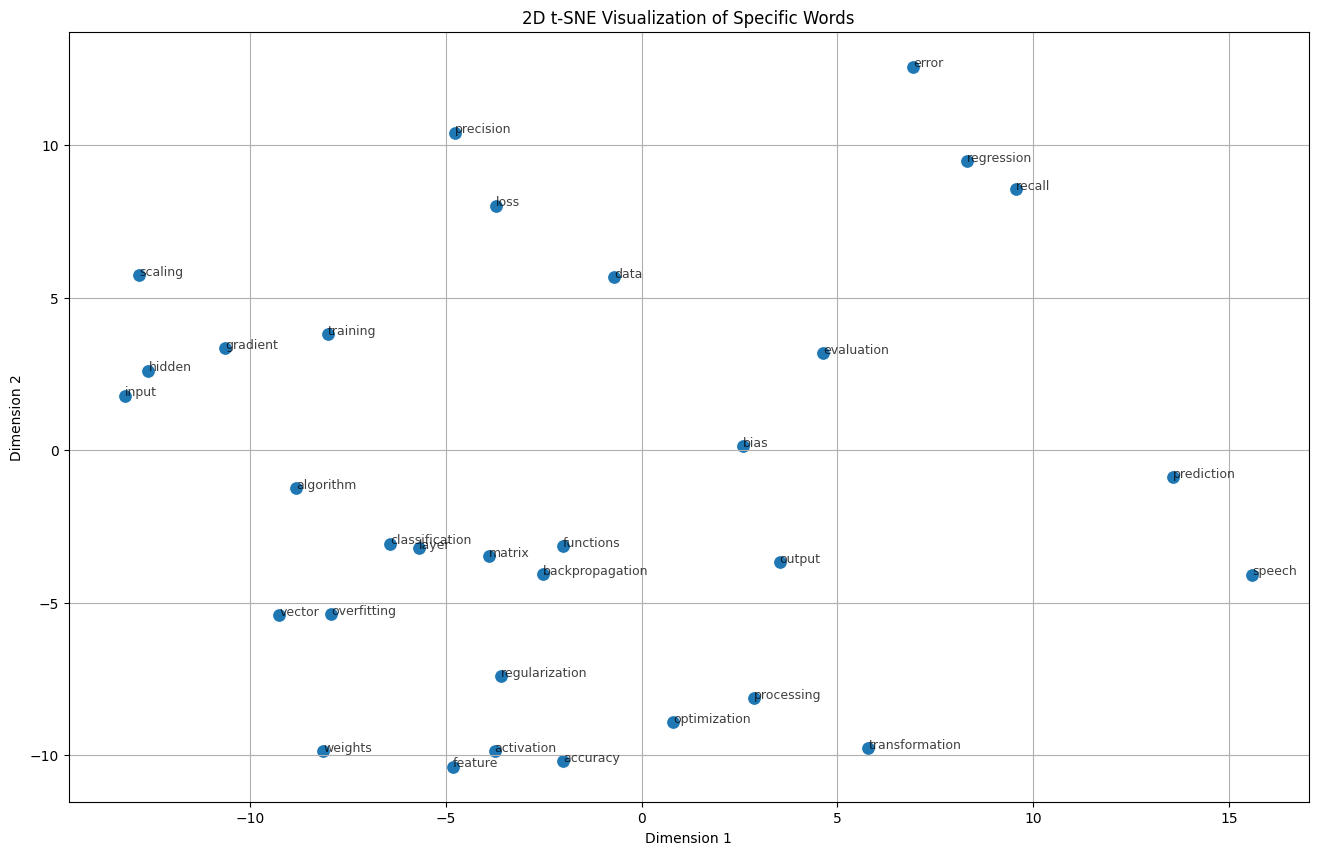

In [12]:
# Load the embeddings DataFrame
embeddings_path_csv = "word_embeddings5.csv"
embeddings_df = pd.read_csv(embeddings_path_csv)

# Extract words and their embeddings
words = embeddings_df['word']
embeddings = embeddings_df.drop('word', axis=1).values

# Apply t-SNE to reduce dimensions to 2
tsne = TSNE(n_components=2, random_state=42)
embeddings_2d = tsne.fit_transform(embeddings)

# Create a new DataFrame for the 2D embeddings
embeddings_2d_df = pd.DataFrame(embeddings_2d, columns=['Dim1', 'Dim2'])
embeddings_2d_df['word'] = words

# Specify the words you want to visualize
specific_words = ["processing", "data", "backpropagation","speech", "gradient",  
    "functions", "algorithm", "training",  "classification", 
    "regression", "accuracy", "precision", "recall",  "error", "optimization",
    "loss", "activation", "layer", "input", "output", "hidden", "weights", "bias",
    "vector", "matrix",  "evaluation", "prediction", "regularization", "overfitting",
    "feature", "scaling", "transformation"
]

# Filter the DataFrame to include only the specific words
filtered_embeddings_2d_df = embeddings_2d_df[embeddings_2d_df['word'].isin(specific_words)]

# Plot the 2D embeddings
plt.figure(figsize=(16, 10))
sns.scatterplot(x='Dim1', y='Dim2', data=filtered_embeddings_2d_df, s=100)

# Annotate points with words
for i, word in enumerate(filtered_embeddings_2d_df['word']):
    plt.annotate(word, (filtered_embeddings_2d_df.iloc[i]['Dim1'], filtered_embeddings_2d_df.iloc[i]['Dim2']), fontsize=9, alpha=0.75)

plt.title('2D t-SNE Visualization of Specific Words')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.grid(True)
plt.show()